### Deep Learning with Pytorch: A 60 Minute Blitz
(Author: Soumith Chintala)

Pytorch有两项重要功能：

- Numpy的替代品，可用来在GPU上进行并行加速运算。（代码中可尽量使用torch包代替numpy包）
- 深度学习框架（其本质上是tensor运算以及自动求导机制）

In [2]:
from __future__ import division, absolute_import, print_function
import torch

#### Tensors

`tensor`是pytorch中的核心类，可查询docs了解详细的方法。如果将tensor的属性`.requires_grad`设置为True,pytorch会追踪所有在该tensor上的运算，当所有的运算完成后，通过调用`.backward()`方法，Pytorch会依据链式法则自动求出每个tensor的梯度，梯度会被保存在`.grad`属性中。

`.detach()`方法重新声明一个变量，指向原变量的存放位置，但是requires_grad为False。其变成了一个叶子节点，截断了反向传播的梯度流，其之前的计算图将不会在计算和保存梯度，从而节省了资源。

在进行evaluation时，我们不需要计算梯度，也就没有必要追踪计算历史，因此可使用`with torch.no_grad()`阻止追踪记录地址。

`Tensor`和`Function`相互配合构成了一个有向无环图，tensor的属性`.grad_fn`记录了产生此结果的直接操作`Function`,在所有的计算都完成后，可通过调用`.backward()`来自动求导。若最终结果是一个标量，则无需再指定额外的参数，若拥有多于１个的元素，则在`.backward()`中还需要给出相同大小的参数输入。

#### A Classification Neural Network

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_set = torchvision.datasets.CIFAR10(root='./data',train=True,download = True, transform = transform)
test_set = torchvision.datasets.CIFAR10(root = './data',train=True,download = True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set,batch_size = 4, shuffle = True, num_workers = 2)
testloader = torch.utils.data.DataLoader(test_set,batch_size = 4, shuffle = True, num_workers = 2)
classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([4, 3, 32, 32])


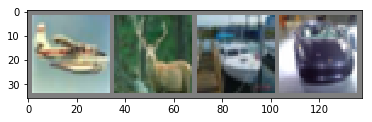

    plane      deer      ship       car


In [5]:
def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
imshow(torchvision.utils.make_grid(images))
print(' '.join('%9s' % classes[labels[j]] for j in range(4)))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
net = Net().to(device)
print(net)
#params = list(net.parameters())
#print(params)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum =0.9)

In [8]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs,labels = data
        inputs,labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d,%5d] loss: {}'.format(epoch+1, i+1,running_loss/2000))
            running_loss = 0.0
print('Finished Training!')

[1, 2000] loss: 2.225
[1, 4000] loss: 1.884
[1, 6000] loss: 1.709
[1, 8000] loss: 1.587
[1,10000] loss: 1.535
[1,12000] loss: 1.486
[2, 2000] loss: 1.406
[2, 4000] loss: 1.386
[2, 6000] loss: 1.362
[2, 8000] loss: 1.327
[2,10000] loss: 1.296
[2,12000] loss: 1.256
Finished Training!


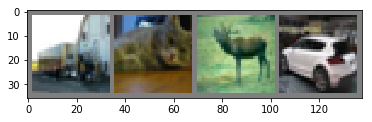

GroundTruth:  truck   cat  deer   car


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images,labels = data
        images,labels = images.to(device),labels.to(device)
        output = net(images)
        _,predicted = torch.max(output.data,1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 54.54 %%


In [21]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images,labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs,1)
        c = (predicted == labels)
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]+= 1
for i in range(10):
    print('Accuracy of {} : {}%'.format(classes[i],100 * class_correct[i]/class_total[i]))

Accuracy of plane : 62.46%
Accuracy of car : 77.0%
Accuracy of bird : 54.26%
Accuracy of cat : 8.88%
Accuracy of deer : 29.34%
Accuracy of dog : 66.54%
Accuracy of frog : 70.3%
Accuracy of horse : 57.94%
Accuracy of ship : 61.2%
Accuracy of truck : 57.48%
